In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 8

# Create xarray region mask

In this tutorial we will show how to create a mask for arbitrary latitude and longitude grids using xarray. It is very similar to the tutorial Create Mask (numpy).

Import regionmask and check the version:

In [2]:
import regionmask
regionmask.__version__

'0.1.0'

Load xarray and the tutorial data:

In [3]:
import xarray as xr
import numpy as np

In [4]:
airtemps = xr.tutorial.load_dataset('air_temperature')

The example data is a temperature field over North America. Let's plot the first time step:

/home/mathause/.local/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


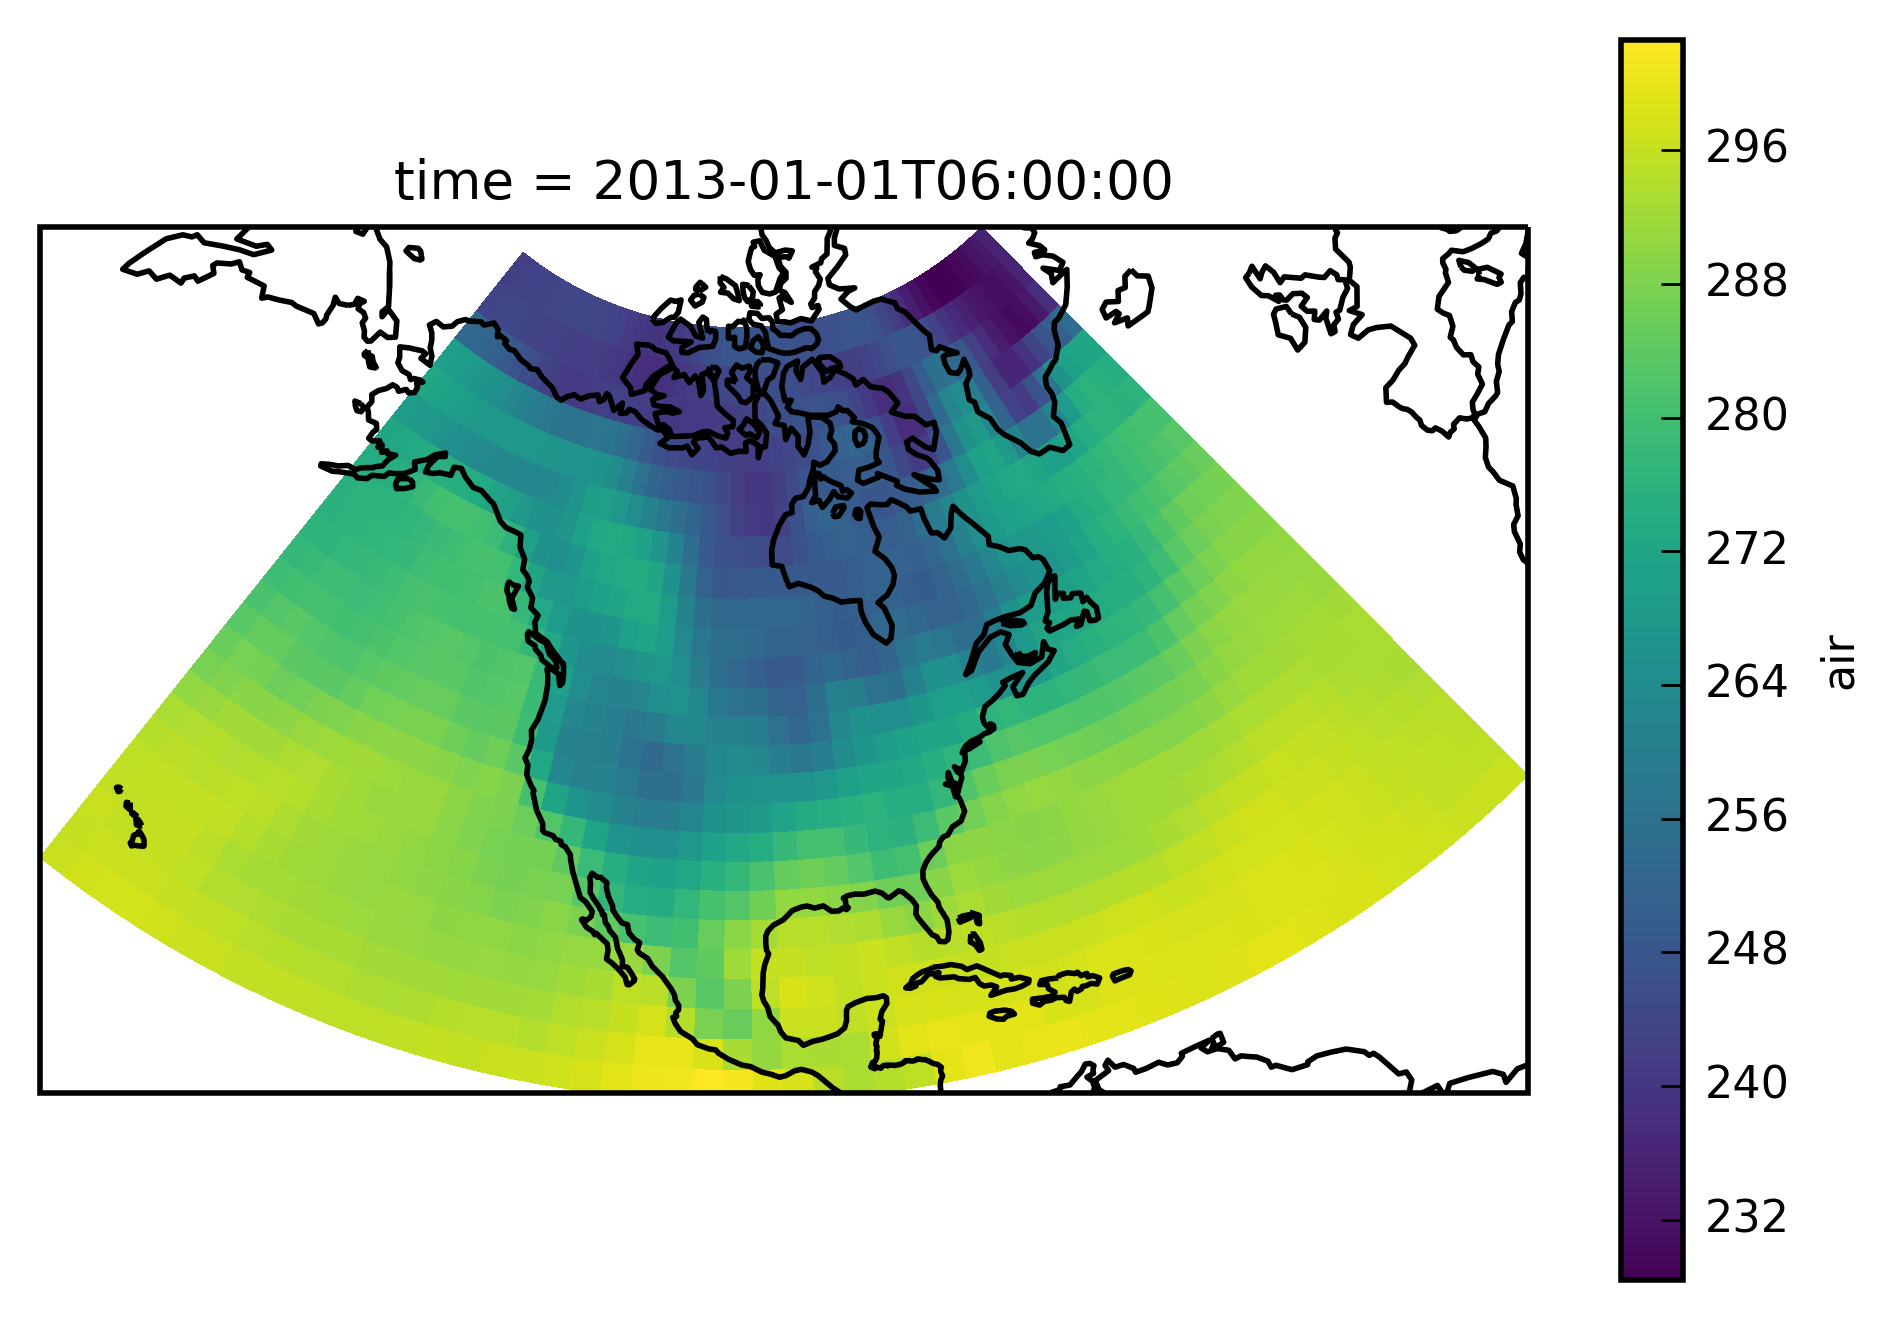

In [5]:
# load cartopy
import cartopy.crs as ccrs

# choose a good projection for regional maps
proj=ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

airtemps.isel(time=1).air.plot.geocolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

Conviniently we can directly pass an xarray object to the `mask` function. It gets the longitude and latitude from the DataArray/ Dataset and creates the `mask`. If the longituda and latitude in the xarray object are not called `lon` and `lat`, respectively; their name can be given via the `lon_name` and `lat_name` keyword. Here we use the Giorgi regions.

In [7]:
mask = regionmask.defined_regions.giorgi.mask(airtemps)
print('All NaN? ',np.all(np.isnan(mask)))

All elements of mask are NaN. Try to set 'wrap_lon=True'.
All NaN?  True


This didn't work - all elements are NaNs! The reason is that airtemps has its longitude from 0 to 360 while the Giorgi regions are defined as -180 to 180. Thus we can provide the `wrap_lon` keyword:

In [8]:
mask = regionmask.defined_regions.giorgi.mask(airtemps, wrap_lon=True)
print('All NaN? ',np.all(np.isnan(mask)))

All NaN?  False


This is better. Let's plot the regions:

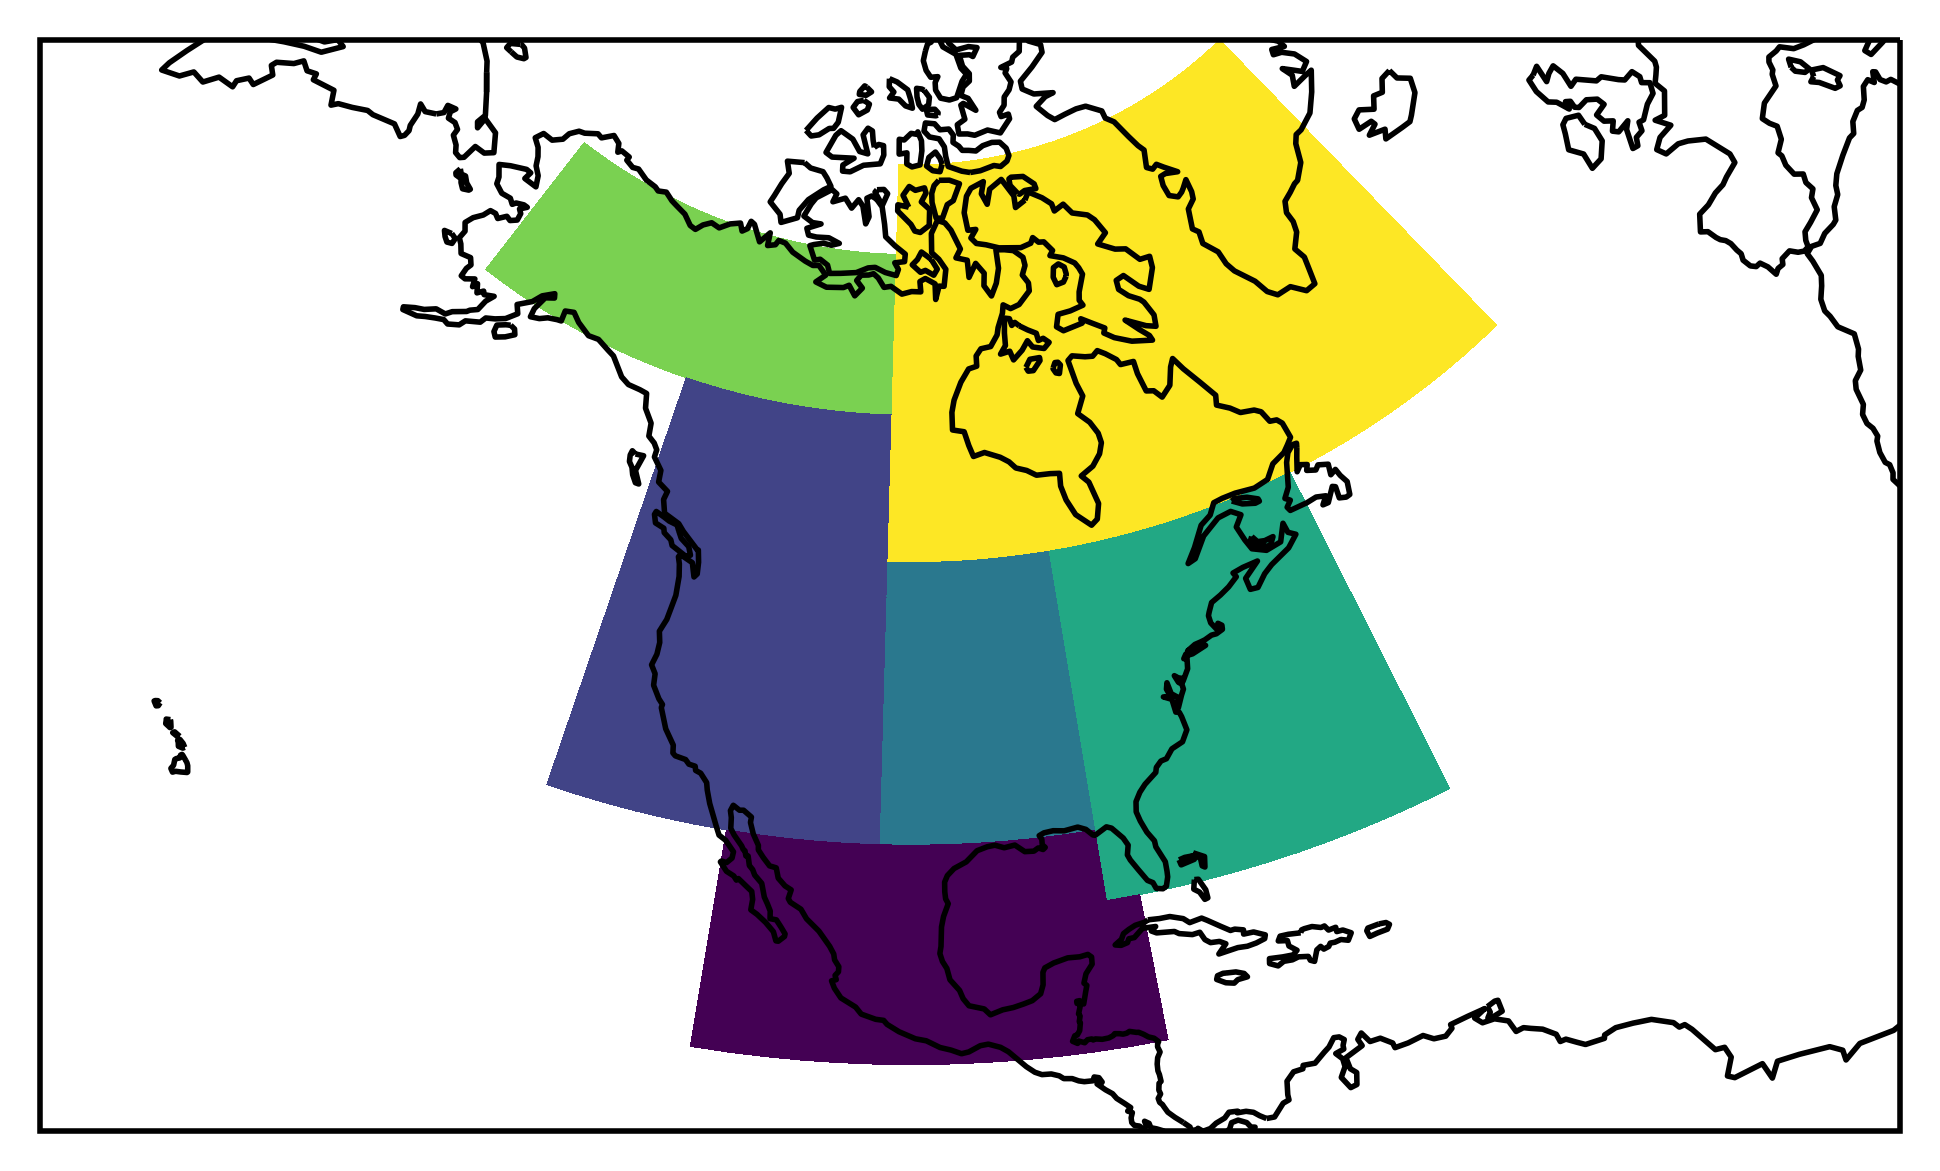

In [9]:
proj=ccrs.LambertConformal(central_longitude=-100)
ax = plt.subplot(111, projection=proj)

low = mask.min()
high = mask.max()

levels = np.arange(low - 0.5, high + 1)

mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), levels=levels, add_colorbar=False)

ax.coastlines()

# fine tune the extent
ax.set_extent([200, 330, 10, 75], crs=ccrs.PlateCarree());

We want to select the region 'Central North America'. Thus we first need to find out which number this is:

In [10]:
regionmask.defined_regions.giorgi.map_keys('Central North America')

6

## Select using `where`

`xarray` provides the handy `where` function:

In [11]:
airtemps_CNA = airtemps.where(mask == 6)

Check everything went well by repeating the first plot with the selected region:

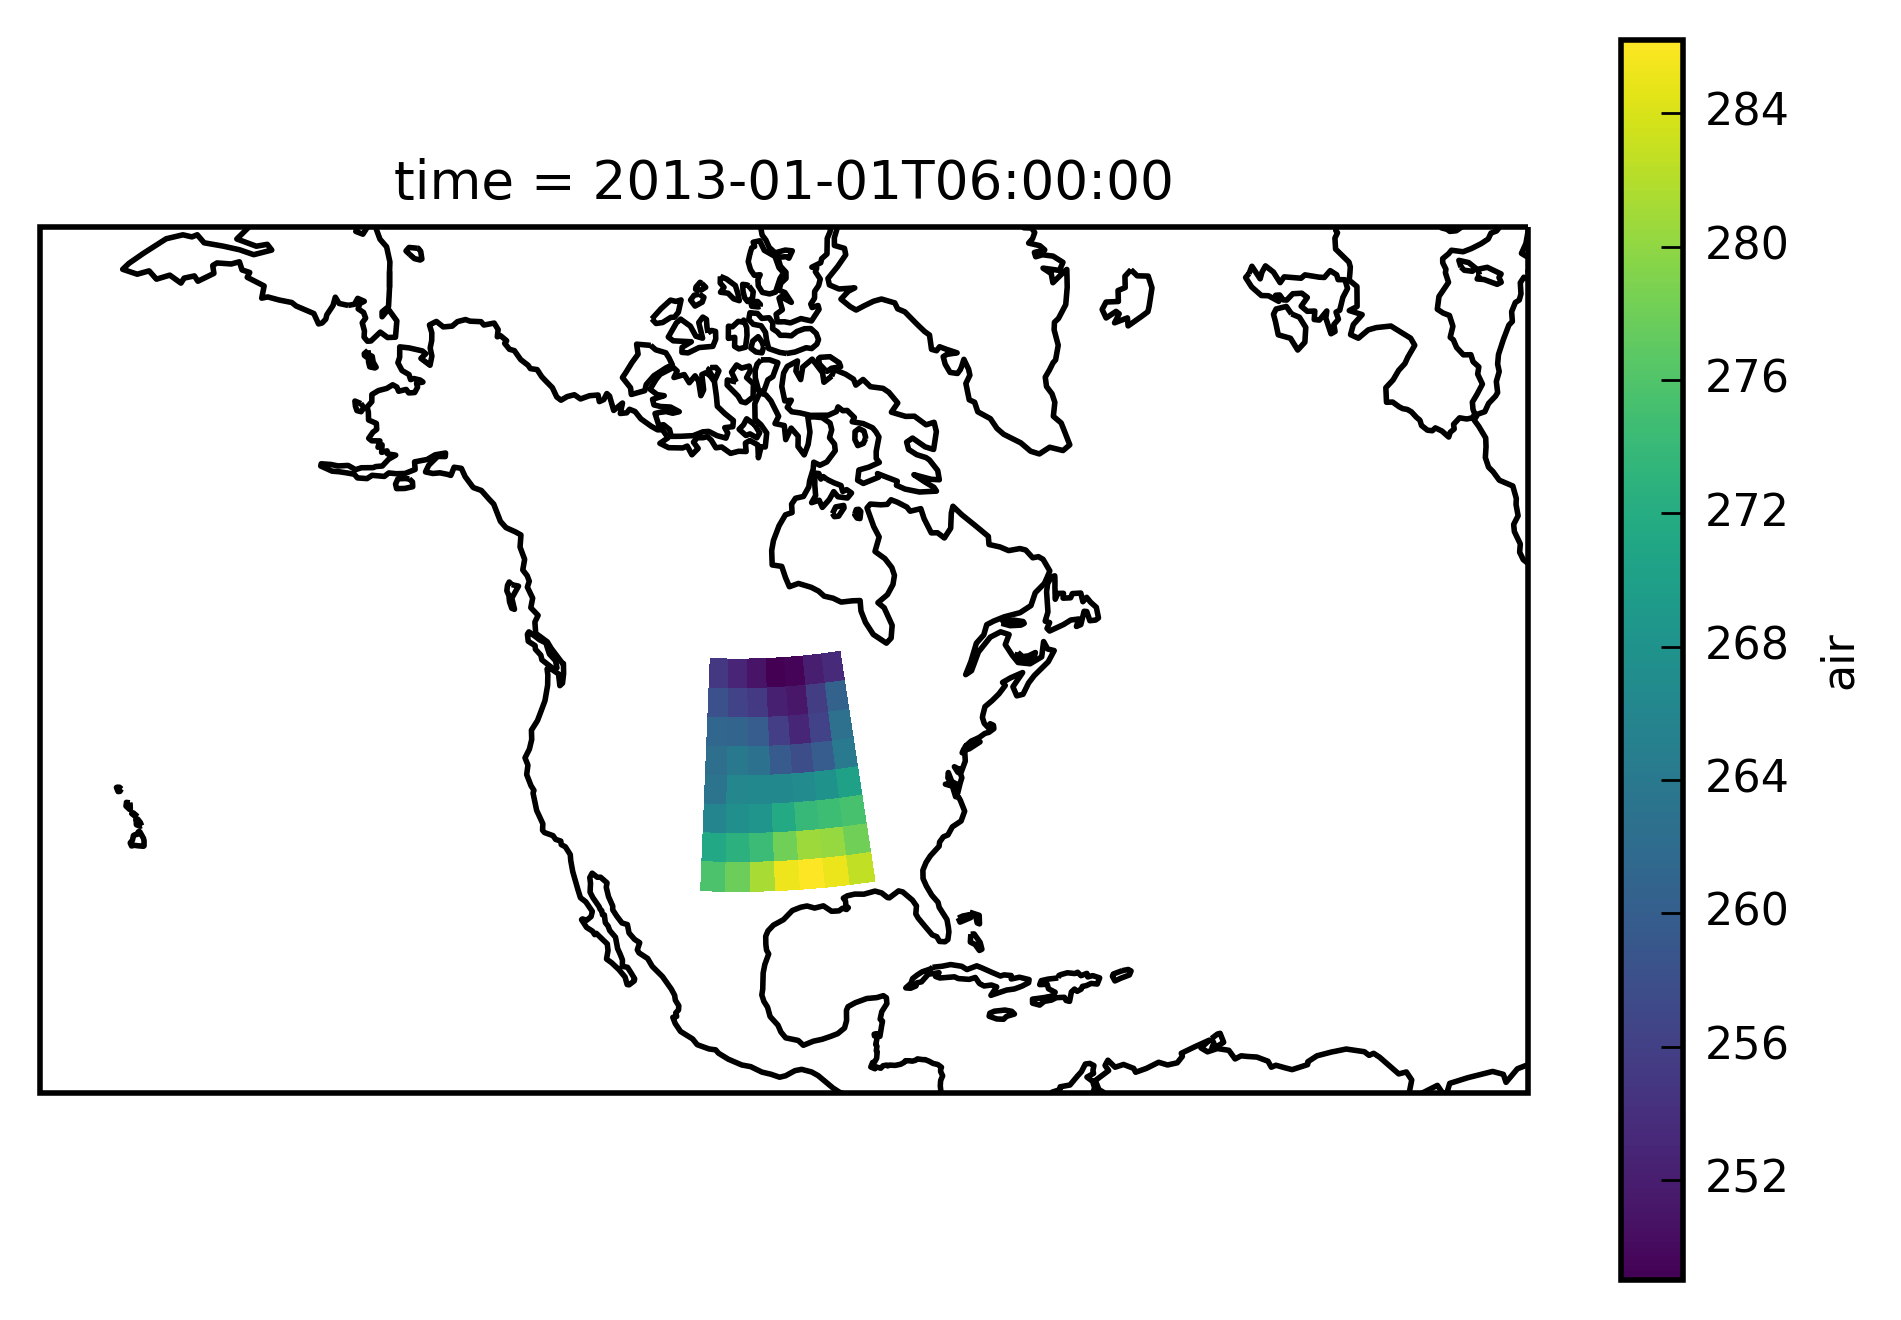

In [12]:
# choose a good projection for regional maps
proj=ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

airtemps_CNA.isel(time=1).air.plot.geocolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

Looks good - let's take the area average and plot the time series. (Note: you should use `cos(lat)` weights to correctly calculate an area average. Unfortunately this is not yet (as of version 0.7) implemented in xarray.) 

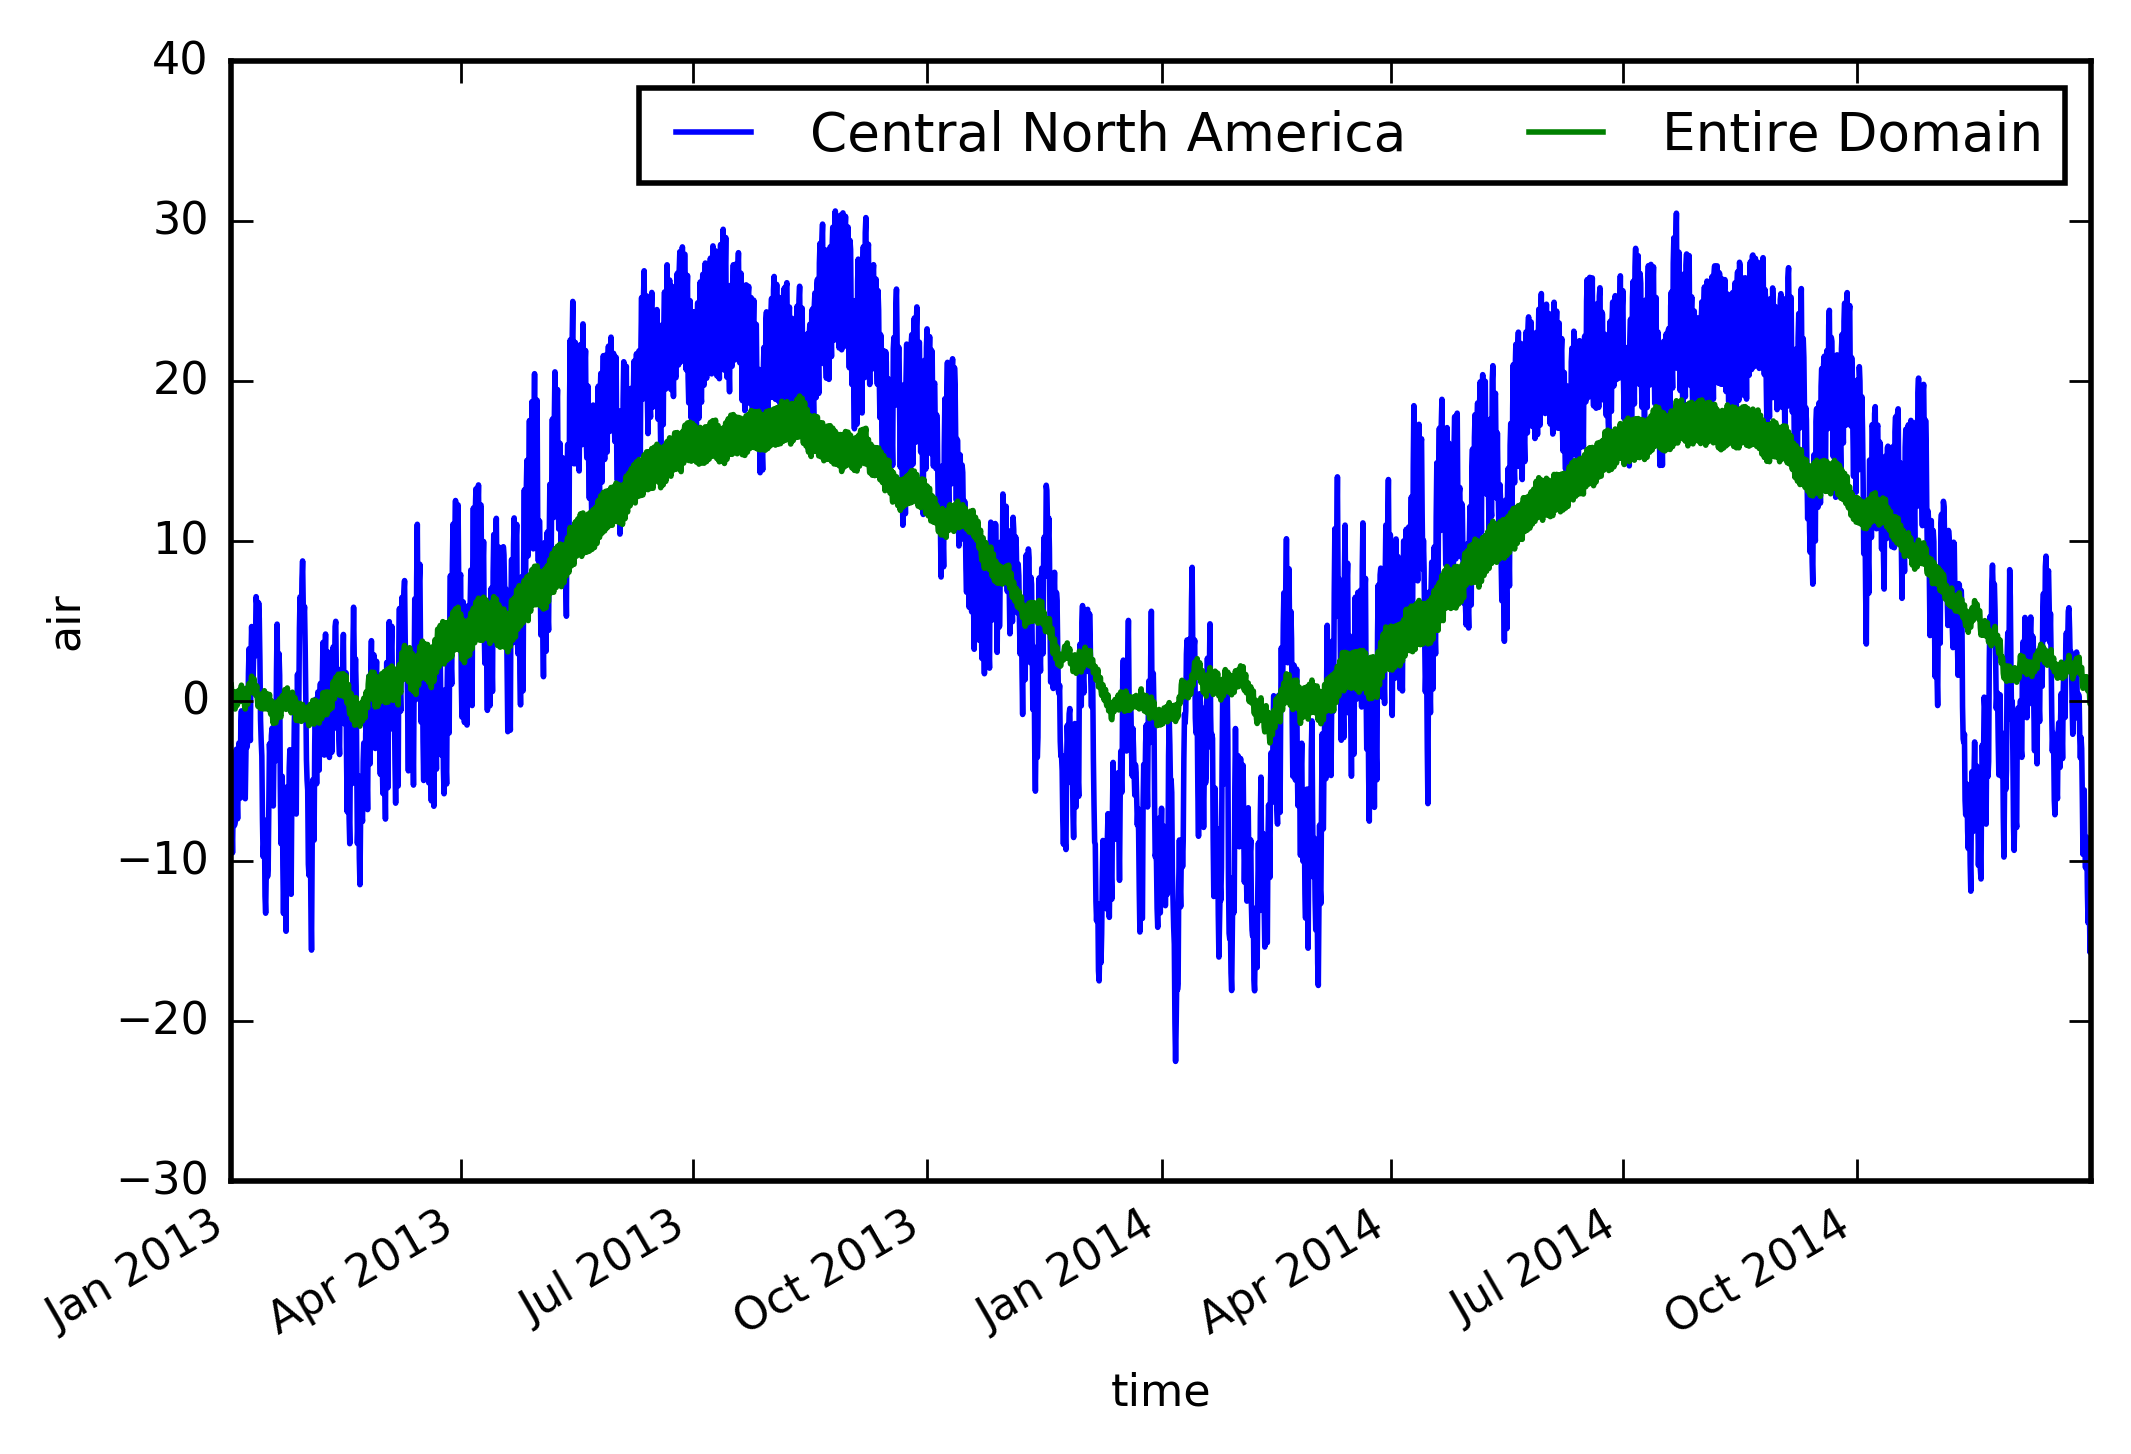

In [13]:
ts_airtemps_CNA = airtemps_CNA.mean(dim=('lat', 'lon')) - 273.15
ts_airtemps = airtemps.mean(dim=('lat', 'lon')) - 273.15

# and the line plot
ts_airtemps_CNA.air.plot.line(label='Central North America')
ts_airtemps.air.plot(label='Entire Domain')

plt.legend(ncol=2)


## Select using `groupby`

In [17]:
# xarray version > 0.8 is required
xr.__version__

'0.7.0-83-gad86a98'

In [25]:
# mask needs a name
mask.name = 'region'

In [26]:
# you can group over all integer values of the mask
# you have to take the mean over `stacked_lat_lon`
airtemps_all = airtemps.groupby(mask).mean('stacked_lat_lon')
airtemps_all

<xarray.Dataset>
Dimensions:  (region: 6, time: 2920)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-01-01T06:00:00 ...
  * region   (region) float64 4.0 5.0 6.0 7.0 8.0 9.0
Data variables:
    air      (region, time) float64 293.6 292.2 291.4 293.6 293.2 291.1 ...

we can add the abbreviations and names of the regions to the DataArray

In [32]:
# extract the abbreviations and the names of the regions from regionmask
abbrevs = regionmask.defined_regions.giorgi[airtemps_all.region.values].abbrevs
names = regionmask.defined_regions.giorgi[airtemps_all.region.values].names

airtemps_all.coords['abbrevs'] = ('region', abbrevs)
airtemps_all.coords['names'] = ('region', names)
airtemps_all

<xarray.Dataset>
Dimensions:  (region: 6, time: 2920)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-01-01T06:00:00 ...
  * region   (region) float64 4.0 5.0 6.0 7.0 8.0 9.0
    abbrevs  (region) |S3 'CAM' 'WNA' 'CNA' 'ENA' 'ALA' 'GRL'
    names    (region) |S21 'Central America' 'Western North America' ...
Data variables:
    air      (region, time) float64 293.6 292.2 291.4 293.6 293.2 291.1 ...

now we can select the regions in many ways

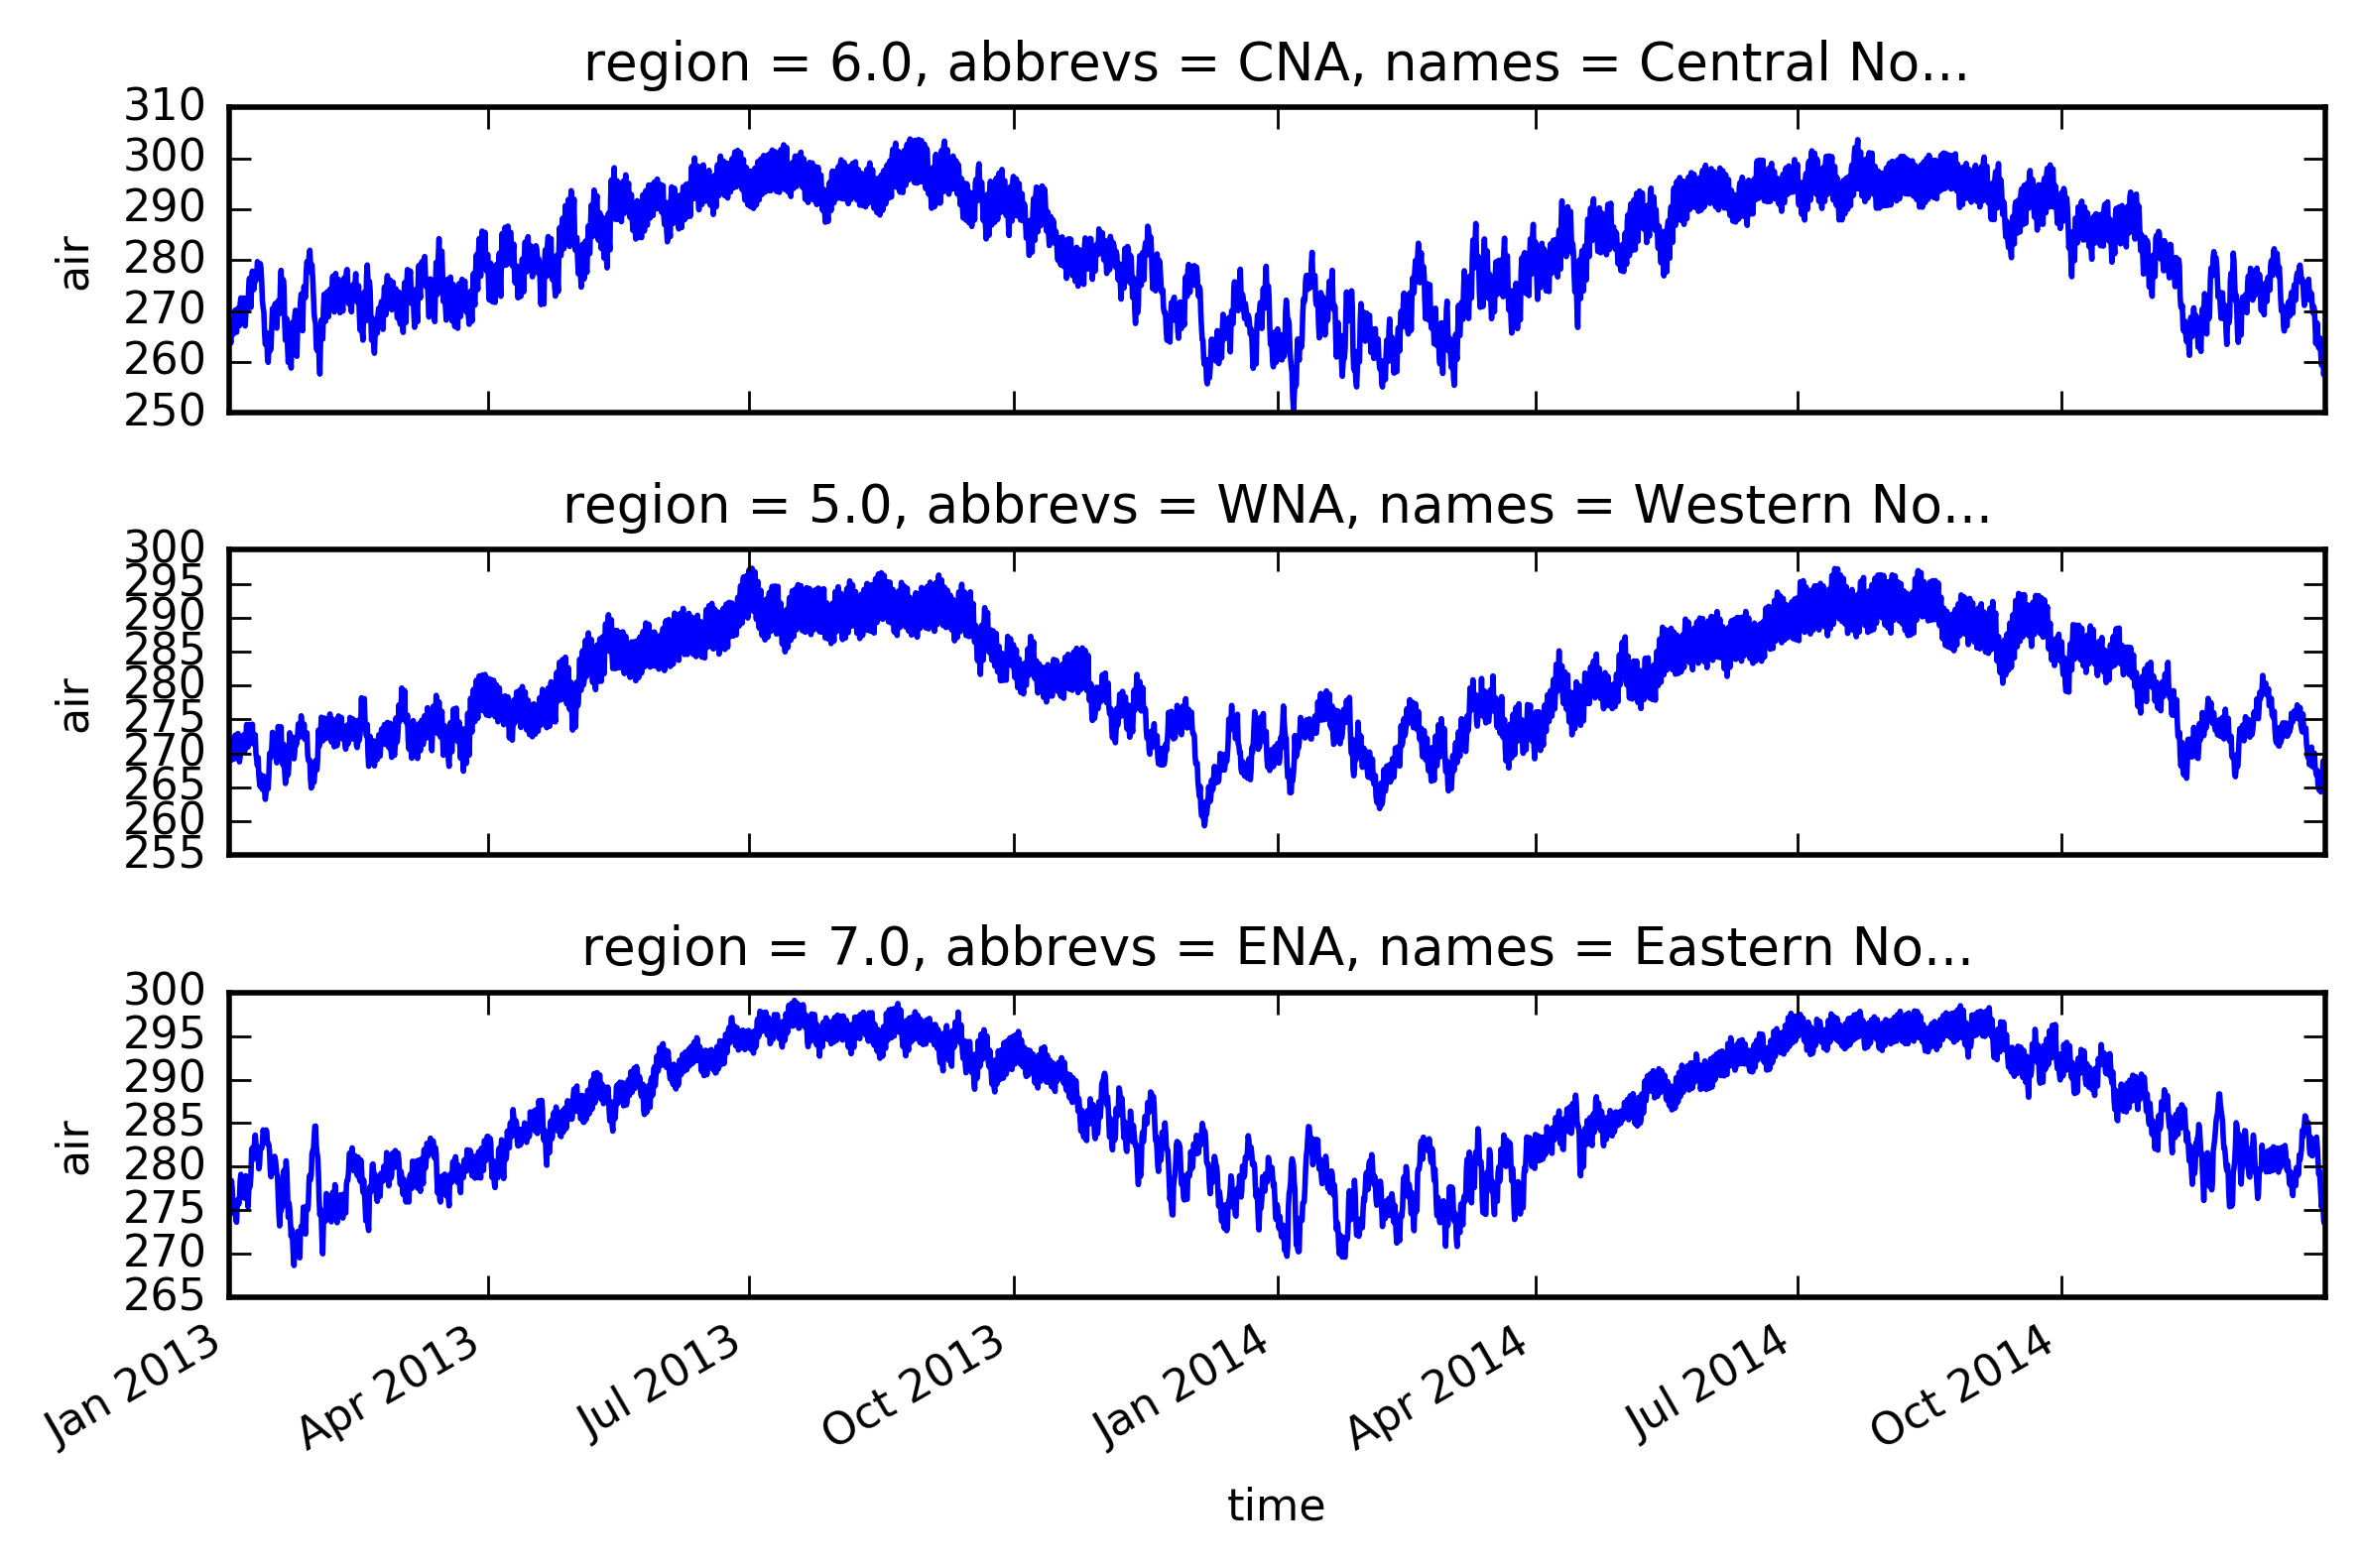

In [44]:
f, axes = plt.subplots(3, 1)

# as before, by the index of the region
ax = axes[0]
airtemps_all.sel(region=6).air.plot(ax=ax)

# with the abbreviation
ax = axes[1]
airtemps_all.isel(region=(airtemps_all.abbrevs == 'WNA')).air.plot(ax=ax)

# with the long name
ax = axes[2]
airtemps_all.isel(region=(airtemps_all.names == 'Eastern North America')).air.plot(ax=ax)

f.tight_layout()